# TP 3 - Monotonie et limiteurs

Julien BLANCHON

In [2]:
# Import des libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Matplotlib formating
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams["figure.autolayout"] = True

# Schéma de `Beam-Warming`

Pour rappel, le schéma de `BW` `EE` limité s’écrit :

$$\begin{aligned}
u_{i}^{n+1} = & u_{i}^{n}-\mathcal{C}\left(u_{i}^{n}-u_{i-1}^{n}\right) \\
&-\frac{\mathcal{C}}{2}(1-\mathcal{C}) \Psi\left(r_{i}\right)\left(u_{i}^{n}-u_{i-1}^{n}\right)+\frac{\mathcal{C}}{2}(1-\mathcal{C}) \Psi\left(r_{i-1}\right)\left(u_{i-1}^{n}-u_{i-2}^{n}\right)
\end{aligned}$$

avec : $r_{i}=\frac{u_{i+1}-u_{i}}{u_{i}-u_{i-1}} \text { et } r_{i-1}=\frac{u_{i}-u_{i-1}}{u_{i-1}-u_{i-2}}$

Pour éviter de divisé par $0$ avec le $u_{i}-u_{i-1}$ par exemple on effectué l'opération suivante

```python
(ui - np.roll(ui, +1)) + eps*((ui - np.roll(ui, +1)) == 0))
```
avec ```eps = 1e-10``` une très petite quantité proche de $0$.

Ainsi pour les `ui` tel que `(ui - np.roll(ui, +1))` soit nul, on ajoute `eps`

In [4]:
def BeamWarming_EE_Limiteur(ui, psi, C=0.5):
    ri = (np.roll(ui, -1) - ui)/ \
        (ui - np.roll(ui, +1) + eps*((ui - np.roll(ui, +1)) == 0))
    ri_moins = (ui - np.roll(ui, +1)) / \
        (np.roll(ui, +1) - np.roll(ui, +2) + eps *
         ((np.roll(ui, +1) - np.roll(ui, +2)) == 0))
    ui_plus = ui - C*(ui - np.roll(ui, +1)) \
                 - 0.5*C*(1-C)*psi(ri)*(ui - np.roll(ui, +1)) \
                 + 0.5*C*(1-C)*psi(ri_moins)*(np.roll(ui, +1) - np.roll(ui, +2))
    return ui_plus


# Schéma de `Lax-Wendroff`

Pour rappel, le schéma de `LW` `EE` limité s’écrit:
$$\begin{aligned}
u_{i}^{n+1}=& u_{i}^{n}-\mathcal{C}\left(u_{i}^{n}-u_{i-1}^{n}\right) \\
&-\frac{\mathcal{C}}{2}(1-\mathcal{C}) \Psi\left(R_{i}\right)\left(u_{i+1}^{n}-u_{i}^{n}\right)+\frac{\mathcal{C}}{2}(1-\mathcal{C}) \Psi\left(R_{i-1}\right)\left(u_{i}^{n}-u_{i-1}^{n}\right)
\end{aligned}$$

avec : $R_{i}=\frac{u_{i}-u_{i-1}}{u_{i+1}-u_{i}}=\frac{1}{r_{i}} \text { et } R_{i-1}=\frac{u_{i-1}-u_{i-2}}{u_{i}-u_{i-1}}=\frac{1}{r_{i-1}}$

In [5]:
eps = np.finfo(float).eps*16

In [6]:
# Schéma d'intégration
def LaxWendroff_EE_Limiteur(ui, psi, C=0.5):
    # u_(i+1)_plus =    u_(i) - C*(u_(i) - u(i-1)) \
    #                 - 0.5*C*(1-C)*Ψ(ri)*(u_(i) - u(i-1)) \
    #                 + 0.5*C*(1-C)*Ψ(ri)*(u_(i-1)-u_(i-1))
    # u_(i+1) = np.roll(ui, shift=-1)
    Ri = (ui - np.roll(ui, +1)) / \
        (np.roll(ui, -1) - ui + eps*((np.roll(ui, -1) - ui) == 0))
    Ri_moins = (np.roll(ui, +1) - np.roll(ui, +2)) / \
        (ui - np.roll(ui, +1) + eps*((ui - np.roll(ui, +1)) == 0))
        
    ui_plus = ui - C*(ui - np.roll(ui, +1)) \
                 - 0.5*C*(1-C)*psi(Ri)*(np.roll(ui, -1) - ui) \
                 + 0.5*C*(1-C)*psi(Ri_moins)*(ui - np.roll(ui, +1))
    return ui_plus


In [7]:
def Lax_Wendroff_EE(ui, C=0.5):
    ui_plus = ui - 0.5*C*(np.roll(ui, shift=-1) - np.roll(ui, shift=+1)) + \
        0.5*C**2*(np.roll(ui, shift=-1) - 2*ui + np.roll(ui, shift=+1))
    return ui_plus


# Objectif du TP

L’objectif de ce TP est d’étudier l’action de limiteurs classiques sur les schémas de `Beam-Warming` et `Lax-Wendroff`.

Pour chacun de ces schémas :
1. Tracer la solution sans limiteur, puis avec les limiteurs suivants :
   - Min-mod : $\Psi(r)= \begin{cases}\min (r, 1) & \text { si } r \geq 0 \\ 0 & \text { sinon }\end{cases} = \max(\min (r, 1), 0)$
   - Superbee : $\Psi(r)=\max [0, \min (2 r, 1), \min (r, 2)]$
   - Van-Leer : $\Psi(r)=\frac{r+|r|}{1+r}$
   - Van-Albada : $\Psi(r)=\frac{r^{2}+r}{r^{2}+1}$

2. Tracer l’évolution temporelle de la variation totale $TV$ , définie comme :
$$T V\left(u^{n}\right)=\sum_{i=1}^{m}\left|u_{i+1}^{n}-u_{i}^{n}\right|$$
3. Commenter l’ensemble des résultats obtenus.

Pour ce TP, on utilisera la condition initiale ”créneau” définie dans le TP 1 (**CI2**) et on observera la solution au terme d’un temps permettant à la solution de revenir à sa position initiale.

In [8]:
# Fonctions de limiteurs Ψ
def identity(r):
    return r

def min_mod(r):
    return np.maximum(np.minimum(r, 1), 0)

def superbee(r):
    return np.maximum(0, np.minimum(2*r, 1), np.minimum(r, 2))

def van_leer(r):
    return (r+np.abs(r))/(1+r + eps*(r==-1))

def van_albada(r):
    return (r**2+r)/(r**2+1)

# Test

In [13]:
# Configuration par defaut
L = 1.0  # Longeur L, 1.0 par défaut
m = 100  # Nombre de point de discrétisation m, par défaut 100
X = np.linspace(start=0, stop=L, num=m)
# X = np.array([i*(L/(m-1)) for i in range(m)])
delta_x = L/(m-1)

In [14]:
# Condition initiale
# Fonction CI1
def CI1(X, beta=2):
    u_zero = np.sin((2*beta*X*np.pi)/L)
    return u_zero

# Fonction CI2
def CI2(X, x0=0.5):
    u_zero = np.array([(0 if xi < x0 else 1) for xi in X])
    return u_zero

In [15]:
# Plot des conditions initiales
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
# u_zero = CI1(X, beta=2)
# ax1.plot(X, CI1(X, beta=2))
# ax2.plot(X, CI2(X, x0=0.5))
# plt.show()

In [16]:
def plot_sol(schema=LaxWendroff_EE_Limiteur, limiteur=None, function_name='CI1', L=1, m=50, C=1.0, a=1.0, beta=1, x0=1.0, P=1,
             trace=False, save=False, show=True, ax=plt):
    X = np.linspace(start=0, stop=L, num=m)
    if function_name == "CI1":
        CI = CI1
        u0 = CI(X, beta)
    elif function_name == "CI2":
        CI = CI2
        u0 = CI(X, x0)
    else:
        CI = function_name
        u0 = CI(X)

    delta_x = L/(m-1)
    delta_t = C*delta_x/np.abs(a)
    tMax = int(1/delta_t)
    tMax = int(tMax/P)
    C = np.sign(a)*C

    # t = t_0
    ut = u0
    ax.plot(X, ut)

    # t = t_i
    for t in range(tMax):
        if limiteur:
            ut = schema(ut, limiteur, C)
        else:
            ut = schema(ut, C)
        if trace:
            ax.plot(X, ut, c=(t/tMax, 0., 0.), alpha=0.01)

    # t = t_max
    if limiteur:
        ut = schema(ut, limiteur, C)
    else:
        ut = schema(ut, C)
    ax.plot(X, ut)
    if ax == plt:
        ax.title(
            f"{CI.__name__}, {schema.__name__}, {limiteur.__name__ if limiteur!=None else None} L={L}, m={m}, C={C}, a={a}, beta={beta}, x0={x0}, Tmax{P}")
        if save:
            ax.savefig(
                f"{CI.__name__}__{schema.__name__}__{limiteur.__name__ if limiteur!=None else None}__L={L}__m={m}__C={C}__a={a}__beta={beta}__x0={x0}__Tmax{P}.png")
        if show:
            ax.show()

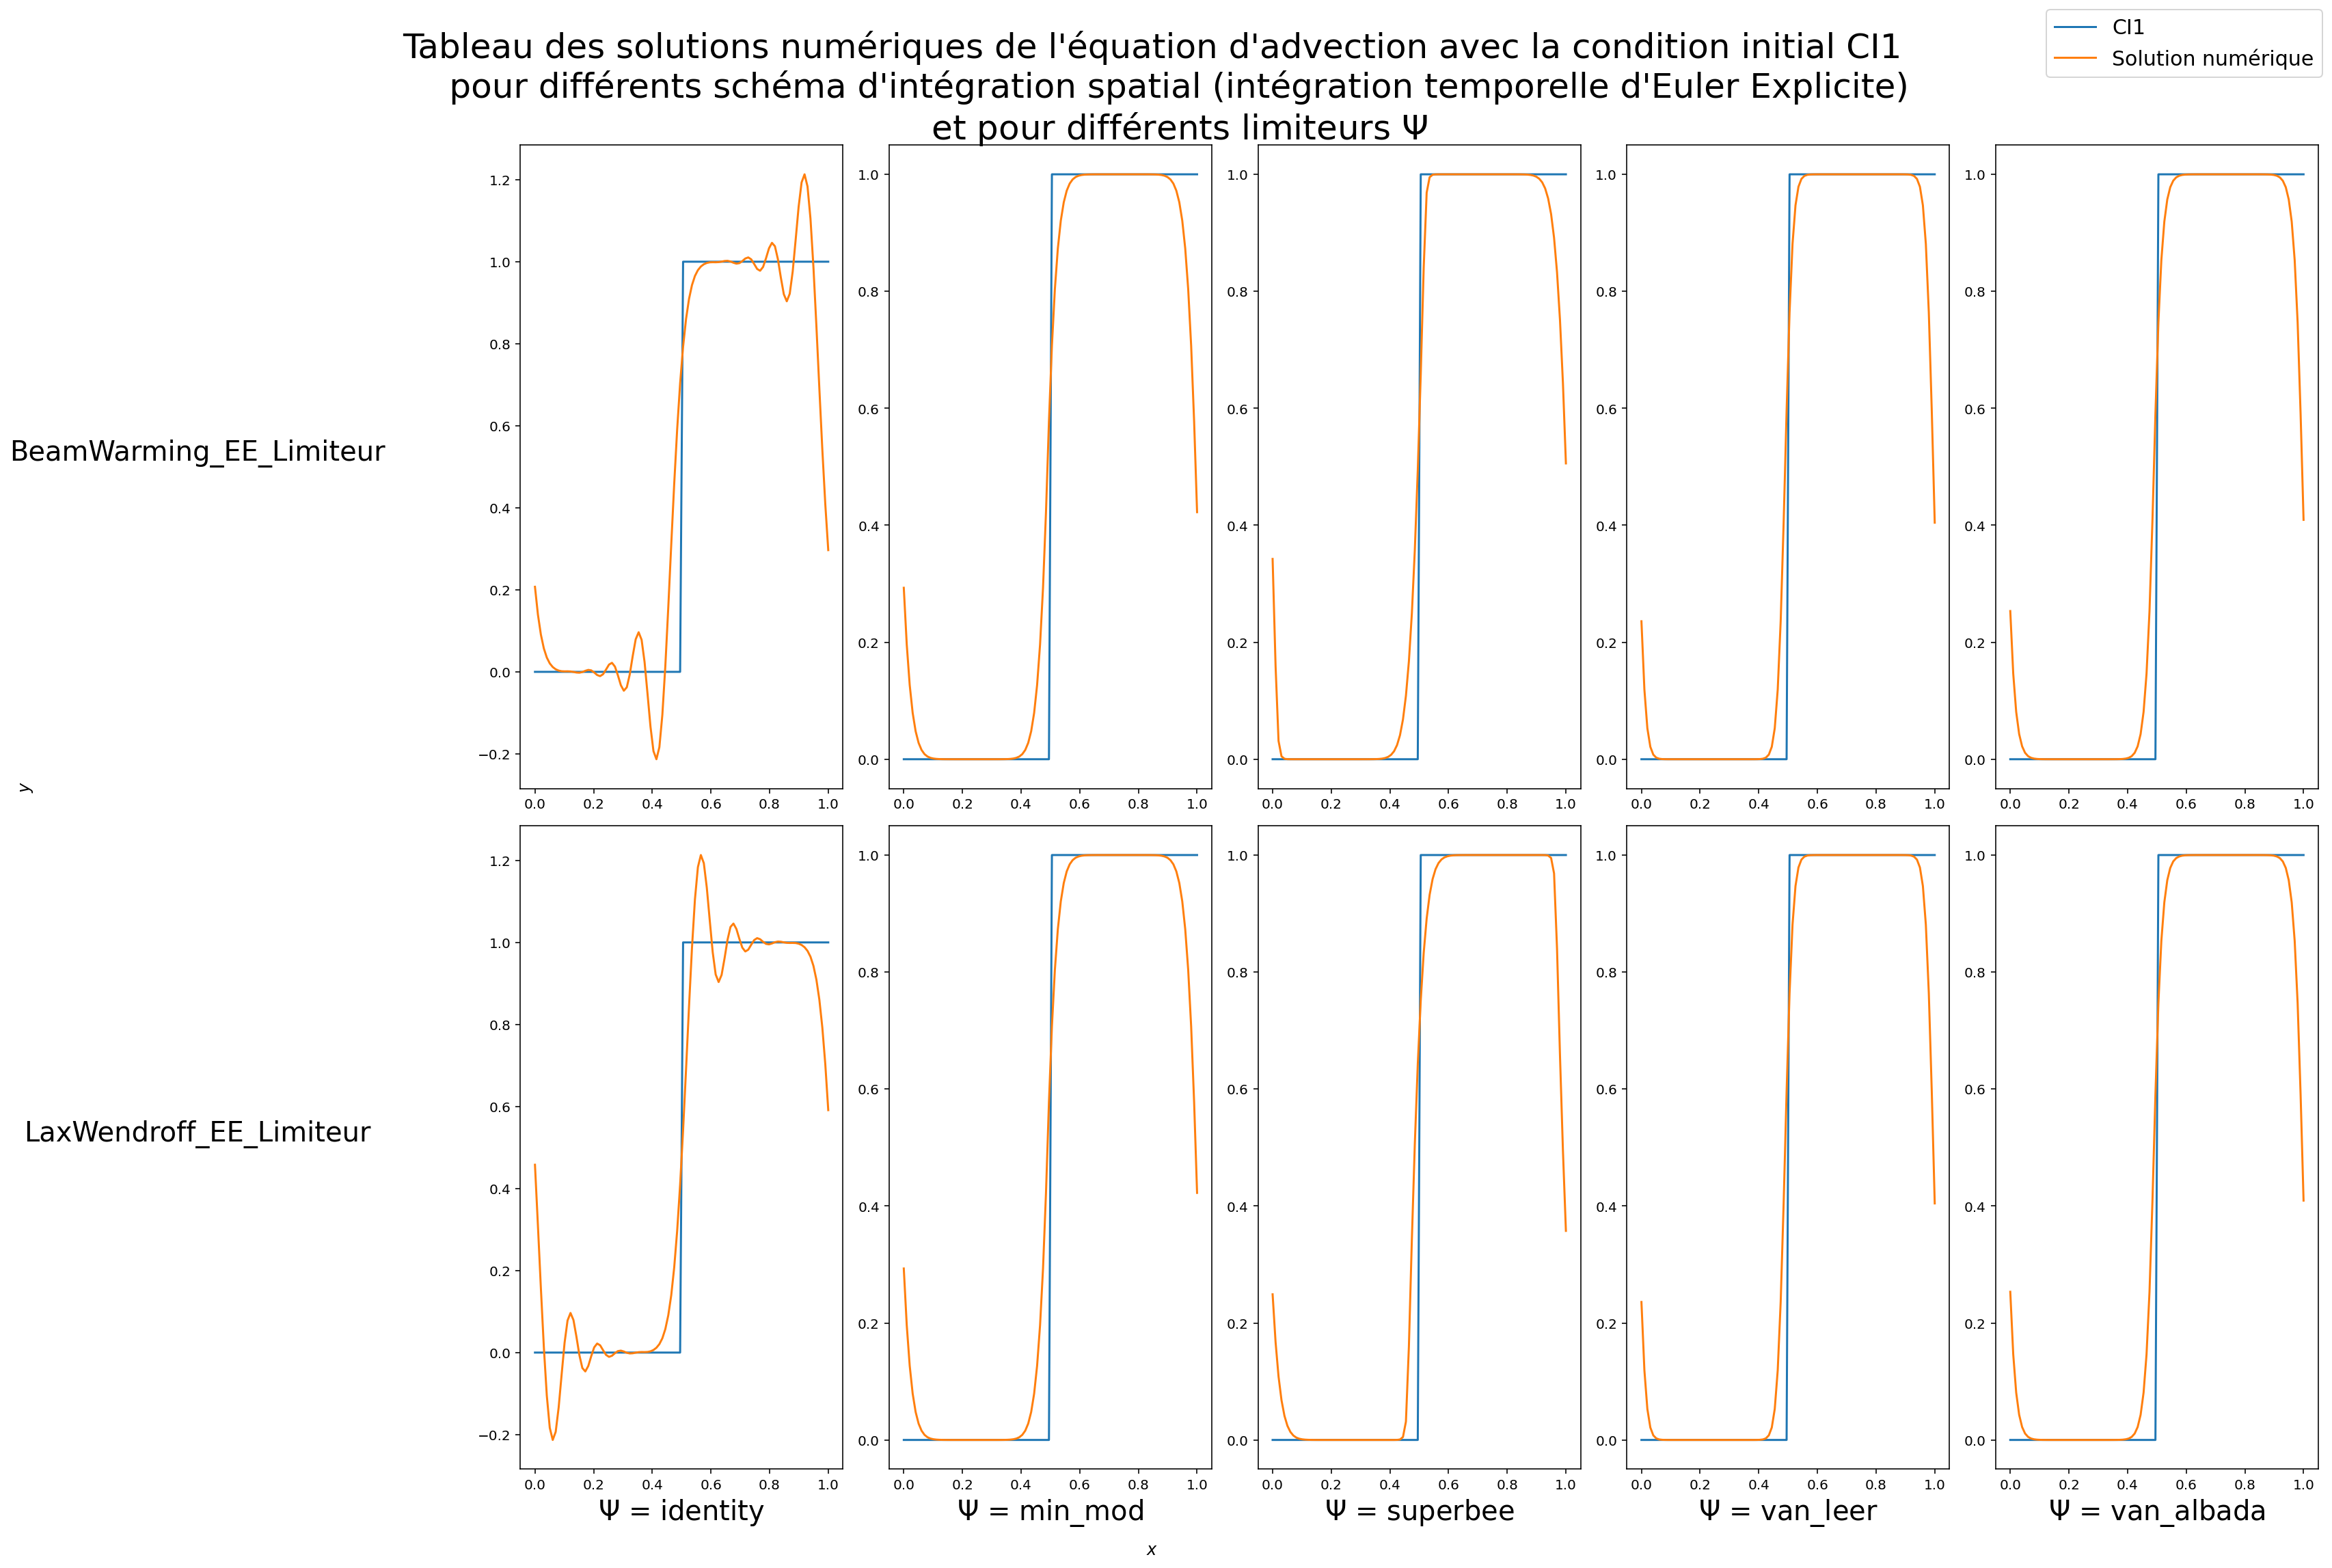

In [17]:
# Variation des solutions selon les limiteurs

schema_list = [BeamWarming_EE_Limiteur, LaxWendroff_EE_Limiteur]
limiteur_list = [identity, min_mod, superbee, van_leer, van_albada]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=len(limiteur_list), figsize=(24, 16))
fig.suptitle(
    "Tableau des solutions numériques de l'équation d'advection avec la condition initial CI1\n \
    pour différents schéma d'intégration spatial (intégration temporelle d'Euler Explicite)\n \
    et pour différents limiteurs $\Psi$", fontsize=25)
fig.supxlabel("$x$")
fig.supylabel("$y$")

for i, schema in enumerate(schema_list):
    axs[i, 0].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i, 0].yaxis.set_label_coords(-1, 0.5)
    for j, limiteur in enumerate(limiteur_list):
        axs[-1, j].set_xlabel(f"$\\Psi$ = {limiteur.__name__ if limiteur!=None else None}", rotation=0,
                              size=20)
        plot_sol(schema=schema, limiteur=limiteur, function_name='CI2', L=1,
                 m=100, C=0.5, a=1.0, beta=2, x0=0.5, P=1, ax=axs[i, j], trace=False)
fig.legend([f"CI1", f"Solution numérique"], fontsize=15)
plt.show()


In [18]:
def TV(ui):
    return np.sum(np.abs(np.roll(ui, -1) - ui))

In [21]:
def plot_TV(schema=LaxWendroff_EE_Limiteur, limiteur=None, function_name='CI1', L=1, m=50, C=1.0, a=1.0, beta=1, x0=1.0, P=1,
             trace=False, save=False, show=True, ax=plt):
    X = np.linspace(start=0, stop=L, num=m)
    if function_name == "CI1":
        CI = CI1
        u0 = CI(X, beta)
    elif function_name == "CI2":
        CI = CI2
        u0 = CI(X, x0)
    else:
        CI = function_name
        u0 = CI(X)

    delta_x = L/(m-1)
    delta_t = C*delta_x/np.abs(a)
    tMax = int(1/delta_t) #1 sec max
    tMax = int(tMax/P)
    C = np.sign(a)*C
    T = np.linspace(start=0, stop=1/P, num=tMax+2)

    TV_list = []
    # t = t_0
    ut = u0
    TV_list.append(TV(ut))

    # t = t_i
    for t in range(tMax):
        if limiteur:
            ut = schema(ut, limiteur, C)
            TV_list.append(TV(ut))
        else:
            ut = schema(ut, C)
            TV_list.append(TV(ut))
            
    # t = t_max
    if limiteur:
        ut = schema(ut, limiteur, C)
        TV_list.append(TV(ut))
    else:
        ut = schema(ut, C)
        TV_list.append(TV(ut))
    ax.plot(T, np.array(TV_list))
    if ax == plt:
        ax.title(
            f"{CI.__name__}, {schema.__name__}, {limiteur.__name__ if limiteur!=None else None} L={L}, m={m}, C={C}, a={a}, beta={beta}, x0={x0}, Tmax{P}")
        if save:
            ax.savefig(
                f"{CI.__name__}__{schema.__name__}__{limiteur.__name__ if limiteur!=None else None}__L={L}__m={m}__C={C}__a={a}__beta={beta}__x0={x0}__Tmax{P}.png")
        if show:
            ax.show()


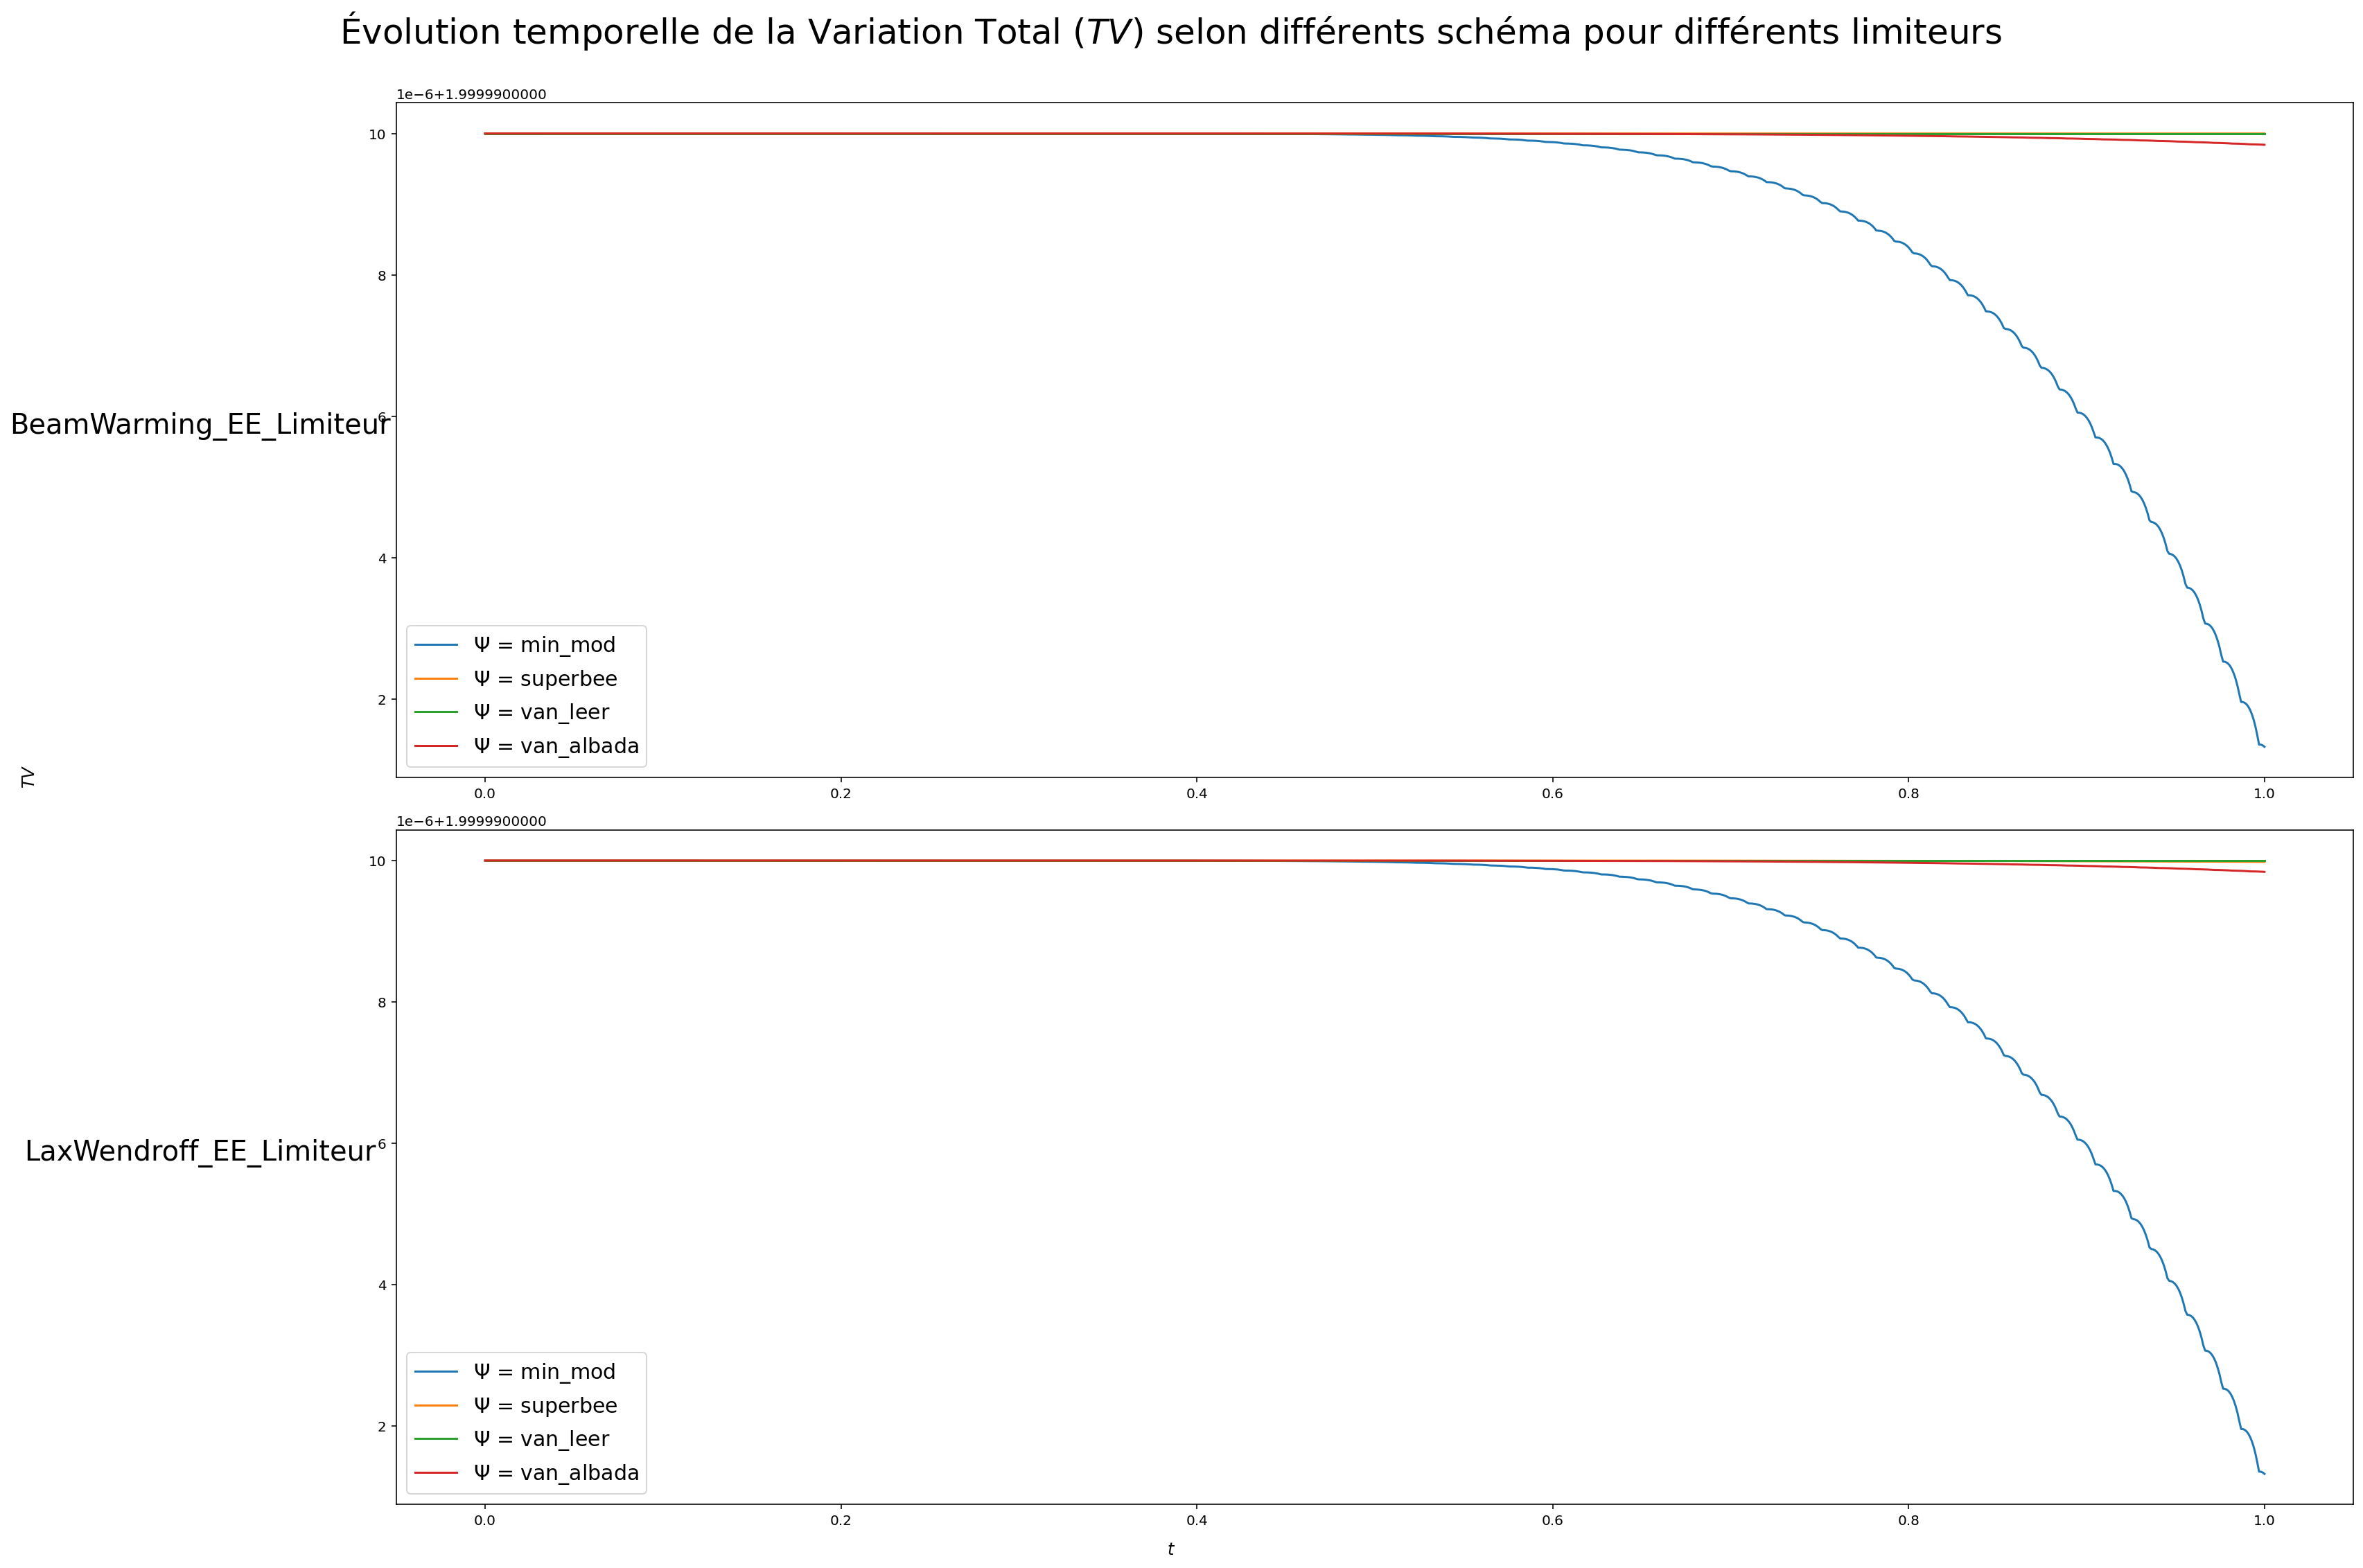

In [23]:
# Plot des Variation Total en fonction du temps
schema_list = [BeamWarming_EE_Limiteur, LaxWendroff_EE_Limiteur]
limiteur_list = [min_mod, superbee, van_leer, van_albada]

fig, axs = plt.subplots(nrows=len(schema_list),
                        ncols=1, figsize=(24, 16))
fig.suptitle(
    "Évolution temporelle de la Variation Total ($TV$) selon différents schéma pour différents limiteurs\n", fontsize=25)
fig.supxlabel("$t$")
fig.supylabel("$TV$")

legend_name = []

for i, schema in enumerate(schema_list):
    axs[i].set_ylabel(f"{schema.__name__}", rotation=0,
                         size=20)
    axs[i].yaxis.set_label_coords(-0.1, 0.5)
    for j, limiteur in enumerate(limiteur_list):
        legend_name.append(f"$\\Psi$ = {limiteur.__name__ if limiteur!=None else None}")

        plot_TV(schema=schema, limiteur=limiteur, function_name='CI2', L=1,
                 m=100, C=0.1, a=1.0, beta=2, x0=0.5, P=1, ax=axs[i], trace=False)
        axs[i].legend(legend_name, fontsize=15)

plt.show()